In [ ]:
#https://github.com/floydhub/named-entity-recognition-template/blob/master/ner.ipynb

In [ ]:
! pip -q install git+https://www.github.com/keras-team/keras-contrib.git sklearn-crfsuite

     |████████████████████████████████| 743 kB 21.9 MB/s 


In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import tensorflow as tf
print(tf.__version__)

1.15.2


In [ ]:
import tensorflow as tf
import keras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [ ]:
# Hyperparams if GPU is available
if tf.test.is_gpu_available():
    BATCH_SIZE = 512  # Number of examples used in each iteration
    EPOCHS = 5  # Number of passes through entire dataset
    MAX_LEN = 75  # Max length of review (in words)
    EMBEDDING = 40  # Dimension of word embedding vector

    
# Hyperparams for CPU training
else:
    BATCH_SIZE = 32
    EPOCHS = 5
    MAX_LEN = 75
    EMBEDDING = 20

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import io
data = pd.read_csv('/content/drive/MyDrive/tv_reviews(1) (1).csv',encoding="latin1")

In [ ]:
data = data.fillna(method="ffill")
print("Number of sentences: ", len(data.groupby(['sentence_id'])))

words = list(set(data["words"].values))
n_words = len(words)
print("Number of words in the dataset: ", n_words)

tags = list(set(data["tags"].values))
print("tags:", tags)
n_tags = len(tags)
print("Number of Labels: ", n_tags)

print("What the dataset looks like:")
# Show the first 10 rows


Number of sentences:  12044
Number of words in the dataset:  5107
tags: ['BOC', 'O', 'IOC']
Number of Labels:  3
What the dataset looks like:


In [ ]:
data.head(n=75)

,Unnamed: 0,sentence_id,words,tags
0,0,sentence:1,value,O
1,1,sentence:1,for,O
2,2,sentence:1,money,O
3,3,sentence:1,completed,O
4,4,sentence:1,using,O
...,...,...,...,...
70,70,sentence:5,sound,O
71,71,sentence:5,quality,O
72,72,sentence:6,nice,BOC
73,73,sentence:6,to,IOC


In [ ]:
class SentenceGetter(object):
    """Class to Get the sentence in this format:
    [(Token_1, Part_of_Speech_1, Tag_1), ..., (Token_n, Part_of_Speech_1, Tag_1)]"""
    def __init__(self, data):
        """Args:
            data is the pandas.DataFrame which contains the above dataset"""
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w,t) for w, t in zip(s["words"].values.tolist(),
                                                           
                                                           s["tags"].values.tolist())]
        self.grouped = self.data.groupby("sentence_id").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        """Return one sentence"""
        try:
            s = self.grouped["sentence:{}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None
        
getter = SentenceGetter(data)
sent = getter.get_next()
print('This is what a sentence looks like:')
print(sent)

This is what a sentence looks like:
[('value', 'O'), ('for', 'O'), ('money', 'O'), ('completed', 'O'), ('using', 'O'), ('a', 'O'), ('year', 'O'), ('now', 'O'), ('some', 'BOC'), ('times', 'IOC'), ('the', 'IOC'), ('screen', 'IOC'), ('cast', 'IOC'), ('or', 'IOC'), ('chrome', 'IOC'), ('cast', 'IOC'), ('gets', 'IOC'), ('stuck', 'IOC'), ('which', 'O'), ('is', 'O'), ('very', 'O'), ('rarely', 'O'), ('but', 'O'), ('this', 'O'), ('issue', 'O'), ('comes', 'O')]


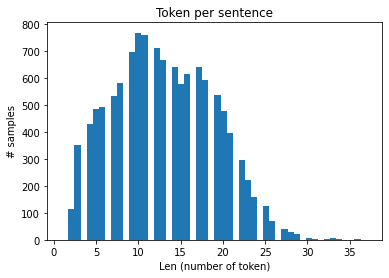

In [ ]:
# Get all the sentences
sentences = getter.sentences

# Plot sentence by lenght
plt.hist([len(s) for s in sentences], bins=50)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [ ]:
# Vocabulary Key:word -> Value:token_index
# The first 2 entries are reserved for PAD and UNK
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1 # Unknown words
word2idx["PAD"] = 0 # Padding

# Vocabulary Key:token_index -> Value:word
idx2word = {i: w for w, i in word2idx.items()}

# Vocabulary Key:Label/Tag -> Value:tag_index
# The first entry is reserved for PAD
tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0

# Vocabulary Key:tag_index -> Value:Label/Tag
idx2tag = {i: w for w, i in tag2idx.items()}

# print("The word Obama is identified by the index: {}".format(word2idx["Obama"]))
# print("The labels B-geo(which defines Geopraphical Enitities) is identified by the index: {}".format(tag2idx["B-geo"]))


from keras.preprocessing.sequence import pad_sequences
# Convert each sentence from list of Token to list of word_index
X = [[word2idx[w[0]] for w in s] for s in sentences]
# Padding each sentence to have the same lenght
X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", value=word2idx["PAD"])

# Convert Tag/Label to tag_index
y = [[tag2idx[w[1]] for w in s] for s in sentences]
# Padding each sentence to have the same lenght
y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=tag2idx["PAD"])

from keras.utils import to_categorical
# One-Hot encode
y = [to_categorical(i, num_classes=n_tags+1) for i in y]  # n_tags+1(PAD)

from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)
X_tr.shape, X_te.shape, np.array(y_tr).shape, np.array(y_te).shape

print('Raw Sample: ', ' '.join([w[0] for w in sentences[0]]))
print('Raw Label: ', ' '.join([w[1] for w in sentences[0]]))
print('After processing, sample:', X[0])
print('After processing, labels:', y[0])

Raw Sample:  value for money completed using a year now some times the screen cast or chrome cast gets stuck which is very rarely but this issue comes
Raw Label:  O O O O O O O O BOC IOC IOC IOC IOC IOC IOC IOC IOC IOC O O O O O O O O
After processing, sample: [3228 3997 4230 4541 1647 4827  483   82 2250 4839 3899 2352 2408 2534
 3766 2408 3088 2786 2665 4543 1796 2905 4678 3001 5032 1310    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]
After processing, labels: [[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 

In [ ]:
print('Raw Sample: ', ' '.join([w[0] for w in sentences[0]]))
print('Raw Label: ', ' '.join([w[1] for w in sentences[0]]))
print('After processing, sample:', X[0])
print('After processing, labels:', y[0])


Raw Sample:  value for money completed using a year now some times the screen cast or chrome cast gets stuck which is very rarely but this issue comes
Raw Label:  O O O O O O O O BOC IOC IOC IOC IOC IOC IOC IOC IOC IOC O O O O O O O O
After processing, sample: [3228 3997 4230 4541 1647 4827  483   82 2250 4839 3899 2352 2408 2534
 3766 2408 3088 2786 2665 4543 1796 2905 4678 3001 5032 1310    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]
After processing, labels: [[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
from gensim.models import FastText
import os
import pathlib
path_to_glove_file = os.path.join(
    os.path.expanduser("~"), "/content/drive/MyDrive/wiki/wiki-news-300d-1M.vec"
)

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))
embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 999995 word vectors.
Found 999995 word vectors.


In [ ]:
EMBEDDING_DIM=300
num_tokens=n_words+2
embedding_matrix = np.zeros((num_tokens, EMBEDDING_DIM))
for word, i in word2idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF
#from tensorflow.keras.layers import Embedding
from keras.layers import Embedding
#embedding_layer = Embedding(
   # num_tokens,
   # embedding_dim,
   # embeddings_initializer=keras.initializers.Constant(embedding_matrix),
   # trainable=False,
#)

# Model definition
input = Input(shape=(MAX_LEN,))
embedding =Embedding(num_tokens, 300, weights=[embedding_matrix], input_length=MAX_LEN, trainable=True)(input) # 
model = Bidirectional(LSTM(units=50, return_sequences=True,recurrent_dropout=0.1))(embedding)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags+1)  # CRF layer, n_tags+1(PAD)
out = crf(model)  # output

model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

model.summary()


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 75, 300)           1532700   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 75, 100)           140400    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 75, 50)            5050      
_________________________________________________________________
crf_1 (CRF)                  (None, 75, 4)             228       
Total params: 1,678,378
Trainable params: 1,678,378
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print(X.shape)
print(np.array(y).shape)
# print(y)


(12044, 75)
(12044, 75, 4)


In [ ]:
history = model.fit(X_tr, np.array(y_tr), batch_size=20, epochs=5,validation_split=0.1, verbose=2)


Train on 9755 samples, validate on 1084 samples
Epoch 1/5
 - 73s - loss: 0.1064 - crf_viterbi_accuracy: 0.9498 - val_loss: 0.0674 - val_crf_viterbi_accuracy: 0.9570
Epoch 2/5
 - 76s - loss: 0.0515 - crf_viterbi_accuracy: 0.9604 - val_loss: 0.0417 - val_crf_viterbi_accuracy: 0.9585
Epoch 3/5
 - 75s - loss: 0.0311 - crf_viterbi_accuracy: 0.9629 - val_loss: 0.0275 - val_crf_viterbi_accuracy: 0.9601
Epoch 4/5
 - 75s - loss: 0.0180 - crf_viterbi_accuracy: 0.9657 - val_loss: 0.0177 - val_crf_viterbi_accuracy: 0.9614
Epoch 5/5
 - 77s - loss: 0.0075 - crf_viterbi_accuracy: 0.9681 - val_loss: 0.0101 - val_crf_viterbi_accuracy: 0.9633


In [ ]:
pred_cat = model.predict(X_te)
pred = np.argmax(pred_cat, axis=-1)
y_te_true = np.argmax(y_te, -1)
print(len(y_te_true))

1205


In [ ]:
from sklearn_crfsuite.metrics import flat_classification_report

# Convert the index to tag
pred_tag = [[idx2tag[i] for i in row] for row in pred]
y_te_true_tag = [[idx2tag[i] for i in row] for row in y_te_true] 
report = flat_classification_report(y_pred=pred_tag, y_true=y_te_true_tag)
print(report)

              precision    recall  f1-score   support

         BOC       0.57      0.52      0.55      1047
         IOC       0.71      0.62      0.66      3728
           O       0.86      0.90      0.88     10796
         PAD       1.00      1.00      1.00     74804

    accuracy                           0.97     90375
   macro avg       0.78      0.76      0.77     90375
weighted avg       0.97      0.97      0.97     90375



In [ ]:
#print(history.history[''])

KeyError: ignored

In [ ]:
print(len(y_te_true_tag))
print(len(pred_tag))
import itertools
flatten = itertools.chain.from_iterable
pred_tag=list(flatten(pred_tag))
y_te_true_tag=list(flatten(y_te_true_tag))
print(len(y_te_true_tag))
print(len(pred_tag))

1205
1205
90375
90375


In [ ]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_te_true_tag,pred_tag)
print(cf_matrix)

[[  547   128   372     0]
 [  159  2304  1265     0]
 [  246   829  9721     0]
 [    0     0     0 74804]]


In [ ]:
tags=['BOC','IOC','O','PAD']

In [ ]:
cm_df = pd.DataFrame(cf_matrix,
                     index=tags, 
                     columns = tags)

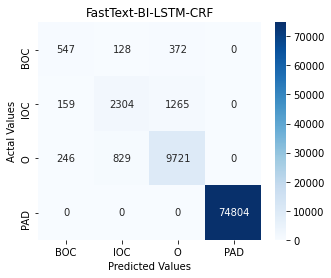

In [ ]:
import seaborn as sns
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True,fmt="d",cmap='Blues')
plt.title('FastText-BI-LSTM-CRF')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.savefig('CM-BI-LSTM-CRF-Fast-tv.jpg')
plt.show()


In [ ]:
from google.colab import files
files.download('CM-BI-LSTM-CRF-Fast-tv.jpg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.download('CausePhrasePlot-mobile.jpg')